### Auto Arima Forecasting in Python

In [5]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('dataset.csv')

df.head()

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869


In [3]:
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=874.416, Time=4.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1602.665, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=913.571, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1392.713, Time=1.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=865.809, Time=7.13 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=2.61 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=867.147, Time=10.86 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=871.437, Time=11.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=868.483, Time=7.09 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=4.38 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=858.292, Time=15.89 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=2.25 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=859.374, Time=1.90 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=860.856, Time=1.57 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total f

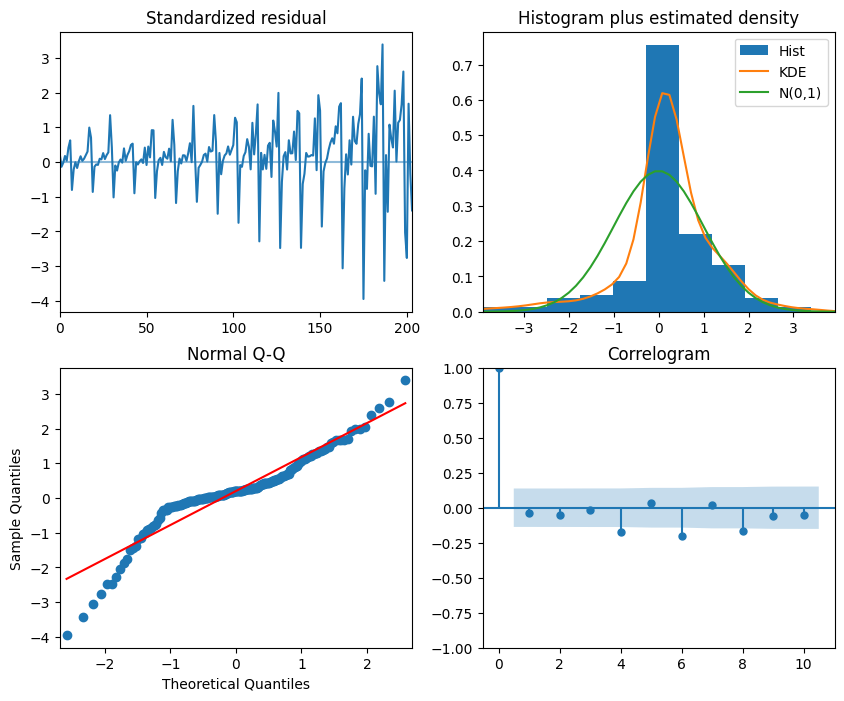

In [6]:
model.plot_diagnostics(figsize=(10,8))
plt.show()

Interpretation of plots in plot diagnostics
Standardized residual: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

Histogram: The density plot suggest normal distribution with mean slighlty shifted towards right.

Theoretical Quantiles: Mostly the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

Correlogram: The Correlogram, (or ACF plot) shows the residual errors are not autocorrelated. The ACF plot would imply that there is some pattern in the residual errors which are not explained in the model. So we will need to look for more X’s (predictors) to the model.

Overall, the model seems to be a good fit. So, let's use it to forecast.

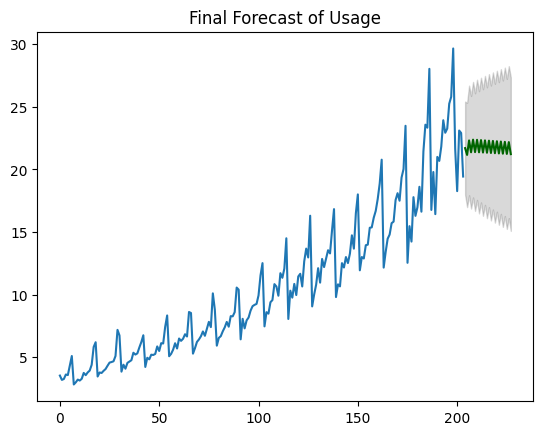

In [7]:
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Usage")
plt.show()

### SARIMA model in python

- The plain ARIMA model has a problem. It does not support seasonality.
- If the time series has defined seasonality, then we should go for Seasonal ARIMA model (in short SARIMA) which uses seasonal differencing.
- Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, we subtract the value from previous season.
- So, the model will be represented as SARIMA(p,d,q)x(P,D,Q), where, P, D and Q are SAR, order of seasonal differencing and SMA terms respectively and 'x' is the frequency of the time series. If the model has well defined seasonal patterns, then enforce D=1 for a given frequency ‘x’.
- We should set the model parameters such that D never exceeds one. And the total differencing ‘d + D’ never exceeds 2. We should try to keep only either SAR or SMA terms if the model has seasonal components.
- Now, we will build a SARIMA model on the time series dataset.

But, first import the dataset

In [9]:
data = pd.read_csv('dataset.csv', parse_dates=['date'], index_col='date')

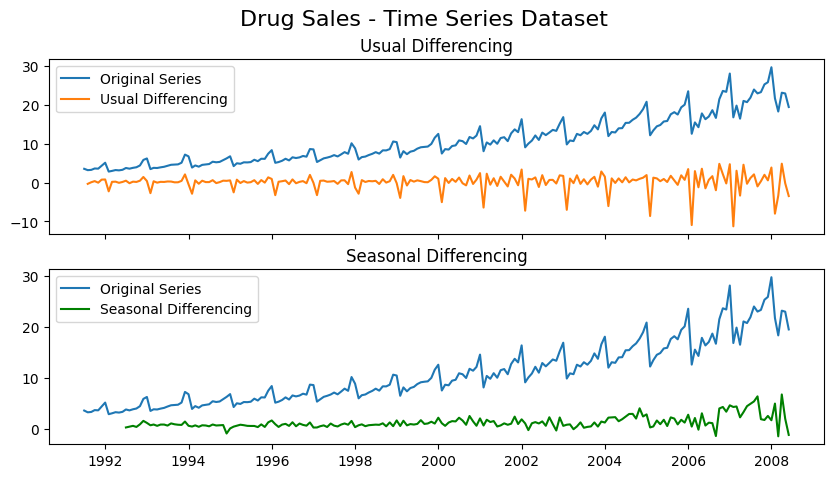

In [10]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Drug Sales - Time Series Dataset', fontsize=16)
plt.show()

- We can see that, the seasonal spikes are intact after applying usual differencing (lag 1). Whereas, it is rectified after seasonal differencing.

- Now, let’s build the SARIMA model using pmdarima‘s auto_arima(). To do so, we need to set seasonal=True, set the frequency m=12 for month wise series and enforce D=1.

In [11]:
import pmdarima as pm
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=534.818, Time=0.85 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=624.061, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=596.068, Time=0.32 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=611.475, Time=0.14 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=757.274, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=559.407, Time=0.15 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=536.817, Time=2.43 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=543.106, Time=0.90 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=537.804, Time=2.45 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=594.467, Time=0.24 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=529.829, Time=1.70 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=555.198, Time=0.60 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.29 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(1, 0, 2)x(1, 1, 2, 12)   Log Likelihood                -253.952
Date:                            Sun, 15 Dec 2024   AIC                            523.903
Time:                                    13:02:22   BIC                            549.963
Sample:                                07-01-1991   HQIC                           534.458
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0053      0.009      0.583      0.560      -0.012       0.023
ar.L1          0.9766      0.018     52.811      0.000       0.940       1.013
ma.L1         -0.9116      0.057    -16.131      0.000      -1.022      -0.801
ma.L2          0.2180      0.059      3.710      0.000       0.103       0.333
ar.S.L12       0.8420      0.155      5.436      0.000       0.538       1.146
ma.S.L12      -1.5836      0.176     -9.004      0.000      -1.928      -1.239
ma.S.L24       0.7665      0.111      6.915      0.000       0.549       0.984
sigma2         0.7476      0.066     11.343      0.000       0.618       0.877
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               143.01
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):              14.45   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The model has estimated the AIC and the P values of the coefficients look significant. Let’s look at the residual diagnostics plot.

The best model SARIMAX(3, 0, 0)x(0, 1, 1, 12) has an AIC of 528.6 and the P Values are significant.

Let’s forecast for the next 24 months.

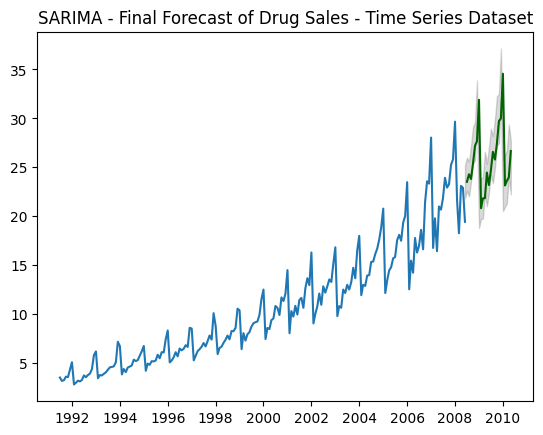

In [12]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of Drug Sales - Time Series Dataset")
plt.show()

There you have a nice forecast that captures the expected seasonal demand pattern.